### No + ZNE(Exponential Extrapolation)

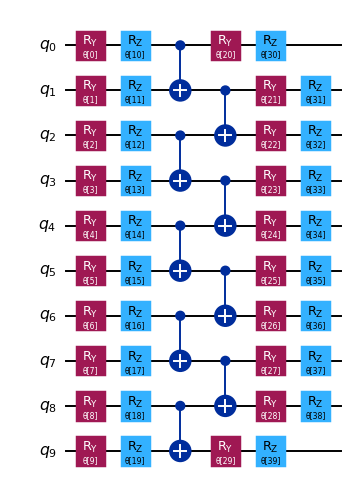

In [126]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

In [127]:
from qiskit.quantum_info import SparsePauliOp

# Z on the last qubit (index -1) with coefficient 1.0
#observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)
observable = SparsePauliOp.from_list([("Z"*n_qubits, 1.0)])
print(observable)

SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])


Mirroring the Circuit

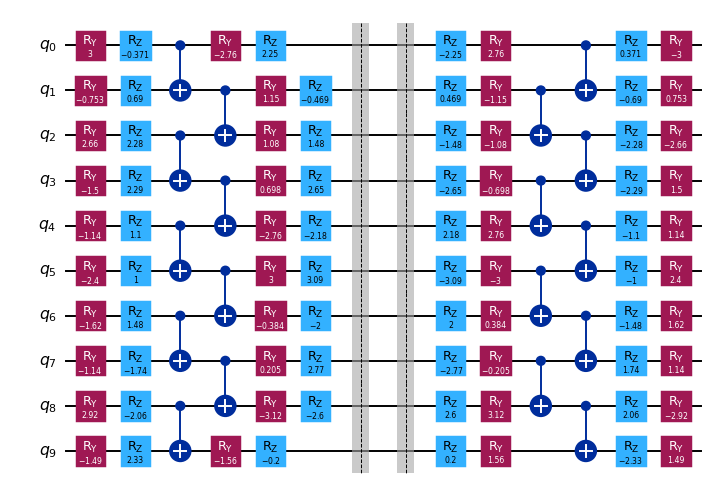

In [128]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

In [129]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='usc/ee520-g/ee520-project',
    token='237d68fbbba3ab1f5663ff574c5813bdd86d098f23b42f6661e7a29846bc3c5653214936822f97fe8e6a53226ca724e19b64baabd705749d8d534de335756557'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='usc/ee520-g/ee520-project', token='<IBM Quantum API key>')

backend = service.least_busy(min_num_qubits=127)

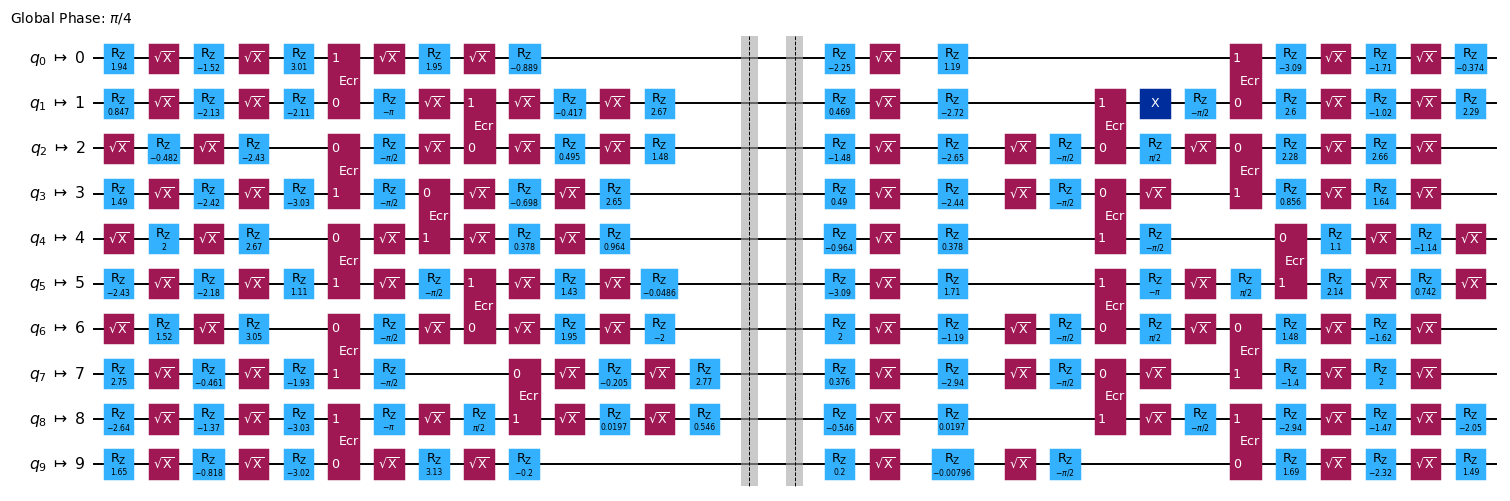

In [130]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

In [131]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZZZZZZ'],
              coeffs=[1.+0.j])


In [135]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 10000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add zero-noise extrapolation (ZNE)
    estimator.options.resilience.zne_mitigation = True
    #estimator.options.resilience.zne.amplifier = ("gate_folding")
    estimator.options.resilience.zne.noise_factors = (1, 2, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("double_exponential")
    job1 = estimator.run([pub])
    jobs.append(job1)

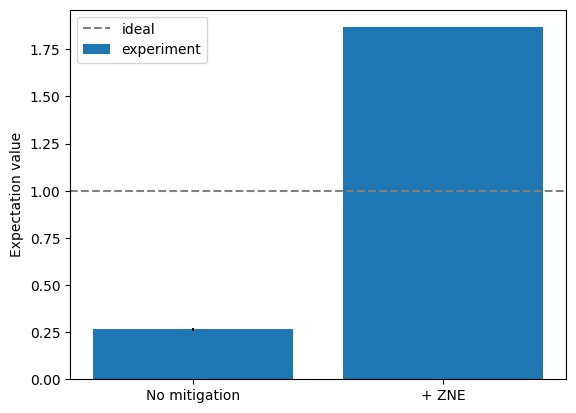

In [136]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

### Mitiq ZNE 

In [89]:
from mitiq import benchmarks
from cirq import DensityMatrixSimulator, depolarize

circuit = benchmarks.generate_rb_circuits(
  n_qubits=1, num_cliffords=2, return_type="cirq",
)[0]


def execute(circuit, noise_level=0.01):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    executed with depolarizing noise.
    """
    noisy_circuit = circuit.with_noise(depolarize(p=noise_level))
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

In [90]:
from mitiq import zne

# Choose a list of scale factors
scale_factors = [1.0, 3.0, 5.0]
# Generate a list of folded circuits
noise_scaled_circuits = [zne.scaling.fold_gates_at_random(circuit, s) for s in scale_factors]

In [91]:
expectation_values = [execute(circ) for circ in noise_scaled_circuits]

In [92]:
zne.ExpFactory.extrapolate(scale_factors, expectation_values, asymptote=0.5)

1.0000000215751552

In [93]:
# Initialize a factory
fac = zne.inference.ExpFactory(scale_factors, asymptote=0.5)

# Load data:
for s, e in zip(scale_factors, expectation_values):
    fac.push({"scale_factor": s}, e)

# Evaluate the extrapolation
fac.reduce()

1.0000000215751552

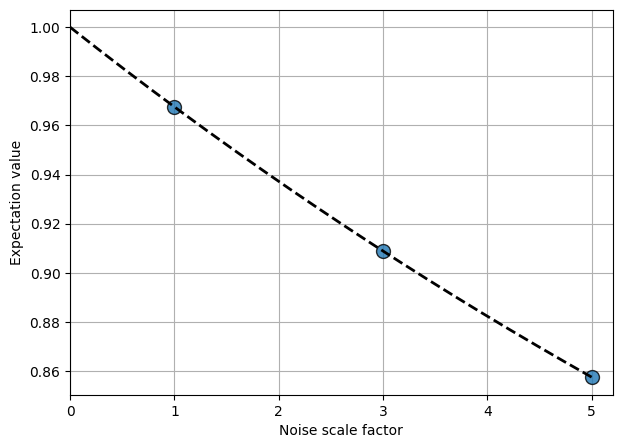

In [94]:
# Plot the extrapolation fit
_ = fac.plot_fit()

### No + ZNE (Linear Extrapolator)

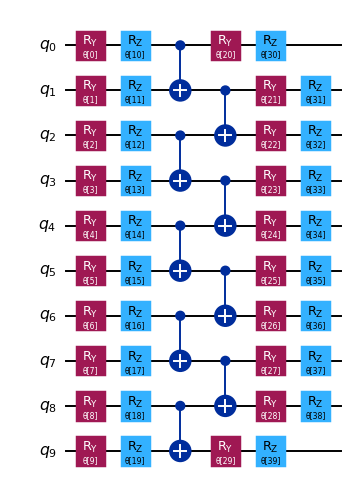

In [137]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

In [138]:
from qiskit.quantum_info import SparsePauliOp

# Z on the last qubit (index -1) with coefficient 1.0
#observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)
observable = SparsePauliOp.from_list([("Z"*n_qubits, 1.0)])
print(observable)

SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])


Mirroring the Circuit

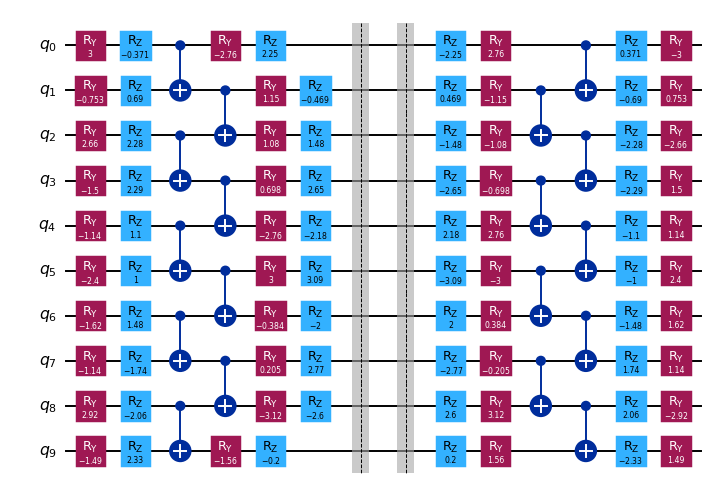

In [139]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

In [140]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='usc/ee520-g/ee520-project',
    token='237d68fbbba3ab1f5663ff574c5813bdd86d098f23b42f6661e7a29846bc3c5653214936822f97fe8e6a53226ca724e19b64baabd705749d8d534de335756557'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='usc/ee520-g/ee520-project', token='<IBM Quantum API key>')

backend = service.least_busy(min_num_qubits=127)

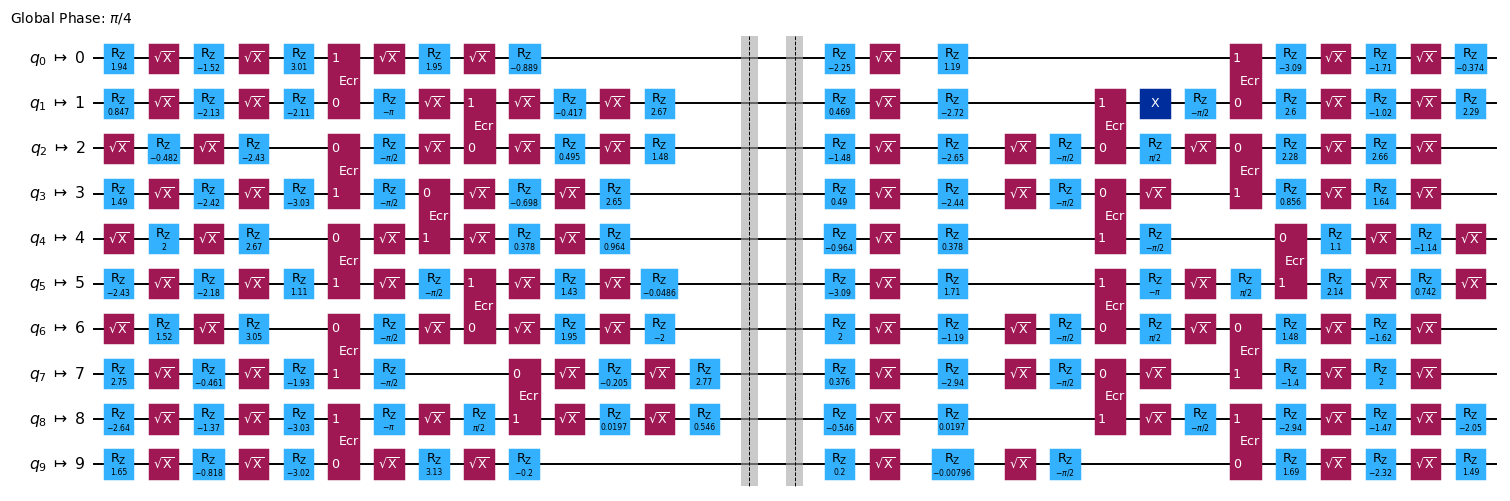

In [141]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

In [142]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZZZZZZ'],
              coeffs=[1.+0.j])


In [143]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 10000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add zero-noise extrapolation (ZNE)
    estimator.options.resilience.zne_mitigation = True
    #estimator.options.resilience.zne.amplifier = ("gate_folding")
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("linear")
    job1 = estimator.run([pub])
    jobs.append(job1)

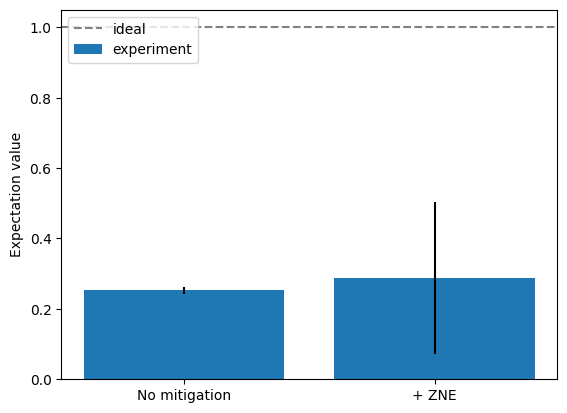

In [144]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

### No + ZNE(Polynomial Extrapolator)

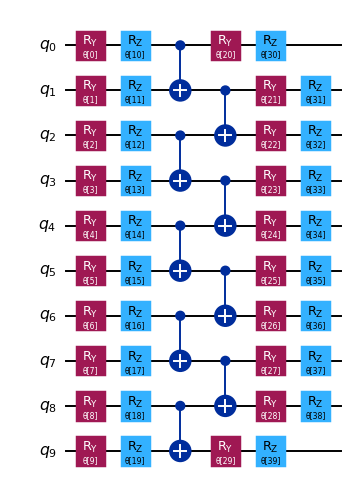

In [145]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

In [146]:
from qiskit.quantum_info import SparsePauliOp

# Z on the last qubit (index -1) with coefficient 1.0
#observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)
observable = SparsePauliOp.from_list([("Z"*n_qubits, 1.0)])
print(observable)

SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])


Mirroring the Circuit

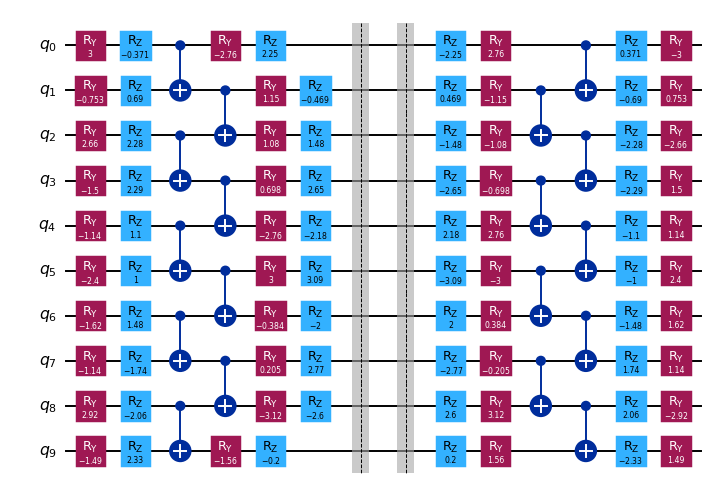

In [147]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

In [148]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='usc/ee520-g/ee520-project',
    token='237d68fbbba3ab1f5663ff574c5813bdd86d098f23b42f6661e7a29846bc3c5653214936822f97fe8e6a53226ca724e19b64baabd705749d8d534de335756557'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='usc/ee520-g/ee520-project', token='<IBM Quantum API key>')

backend = service.least_busy(min_num_qubits=127)

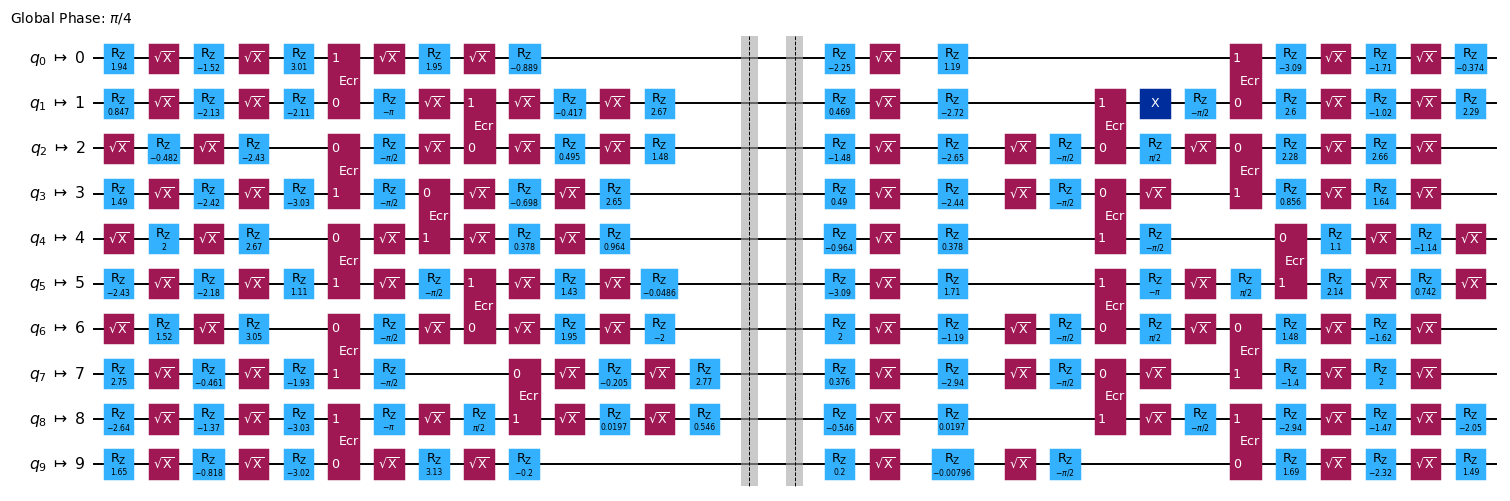

In [149]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

In [150]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZZZZZZ'],
              coeffs=[1.+0.j])


In [153]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 10000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add zero-noise extrapolation (ZNE)
    estimator.options.resilience.zne_mitigation = True
    #estimator.options.resilience.zne.amplifier = ("gate_folding")
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("polynomia_degree_1")
    job1 = estimator.run([pub])
    jobs.append(job1)

ValidationError: 3 validation errors for ZneOptions
extrapolator.is-instance[UnsetType]
  Input should be an instance of UnsetType [type=is_instance_of, input_value='polynomia_degree_1', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/is_instance_of
extrapolator.literal['linear','exponential','double_exponential','polynomial_degree_1','polynomial_degree_2','polynomial_degree_3','polynomial_degree_4','polynomial_degree_5','polynomial_degree_6','polynomial_degree_7','fallback']
  Input should be 'linear', 'exponential', 'double_exponential', 'polynomial_degree_1', 'polynomial_degree_2', 'polynomial_degree_3', 'polynomial_degree_4', 'polynomial_degree_5', 'polynomial_degree_6', 'polynomial_degree_7' or 'fallback' [type=literal_error, input_value='polynomia_degree_1', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/literal_error
extrapolator.json-or-python[json=list[literal['linear','exponential','double_exponential','polynomial_degree_1','polynomial_degree_2','polynomial_degree_3','polynomial_degree_4','polynomial_degree_5','polynomial_degree_6','polynomial_degree_7','fallback']],python=chain[is-instance[Sequence],function-wrap[sequence_validator()]]]
  'str' instances are not allowed as a Sequence value [type=sequence_str, input_value='polynomia_degree_1', input_type=str]

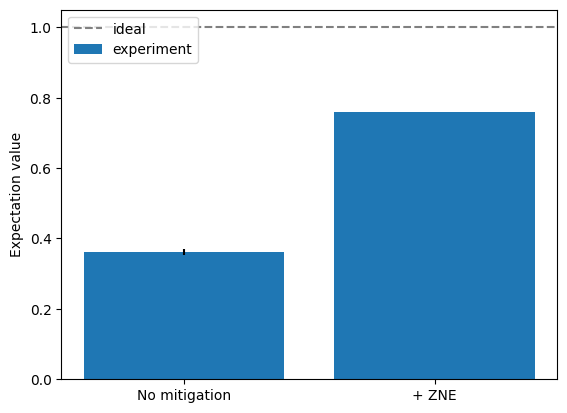

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()